# Exploring the Python AST Ecosystem

- H. Chase Stevens
- Senior Data Science Engineer at <img style='display:inline; margin: 0' src='teikametrics-logo-75.png'>
- @hchasestevens on twitter
- http://github.com/hchasestevens/europython-2018

In [4]:
import ast
import astor
import showast

## What you should get out of this talk:
- ASTs aren't scary!
- AST-based tooling for:
  - static analysis
  - code manipulation
- Practical examples
- Resources for writing your own AST tooling

## What I want to get out of this talk:

<center><img src='prometheus.png' /></center>

# What is an AST?

In [2]:
x = 1 + 2

In [3]:
import ast
parsed = ast.parse("x = 1 + 2")
parsed

In [4]:
ast.dump(parsed)

"Module(body=[Assign(targets=[Name(id='x', ctx=Store())], value=BinOp(left=Num(n=1), op=Add(), right=Num(n=2)))])"

In [5]:
import astor
astor.dump_tree(parsed.body[0])

"Assign(targets=[Name(id='x')], value=BinOp(left=Num(n=1), op=Add, right=Num(n=2)))"

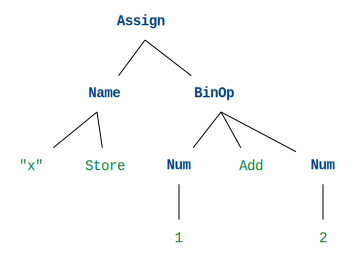

In [22]:
%%showast
x = 1 + 2

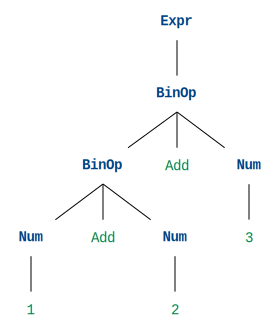

In [17]:
%%showast
1 + 2 + 3

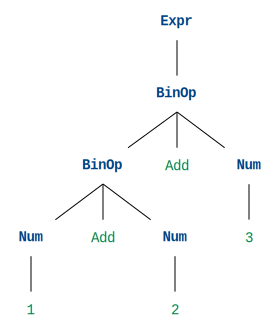

In [18]:
%%showast
(1 + 2) + 3

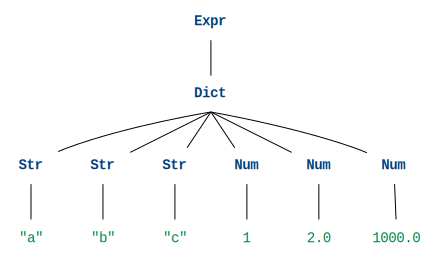

In [19]:
%%showast
{'a': 1, 'b': 2.0, 'c': 1e3}

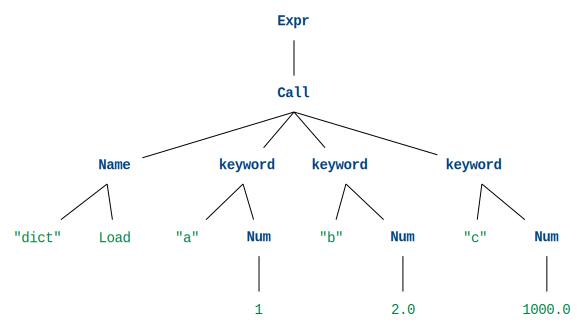

In [20]:
%%showast
dict(a=1, b=2.0, c=1e3)

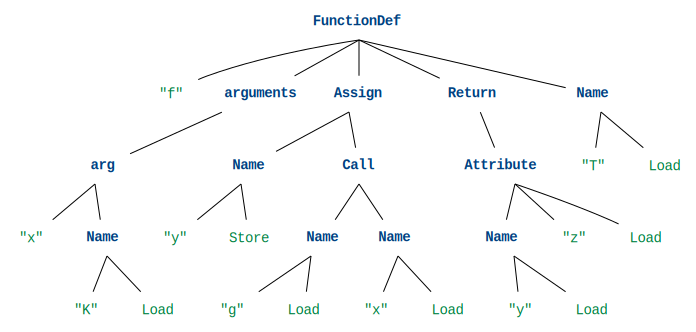

In [21]:
%%showast
def f(x: K) -> T:
    y = g(x)
    return y.z

In [12]:
print(astor.dump_tree(ast.parse("""
def f(x: K) -> T:
    y = g(x)
    return y.z
""").body[0]))

FunctionDef(name='f',
    args=arguments(args=[arg(arg='x', annotation=Name(id='K'))],
        vararg=None,
        kwonlyargs=[],
        kw_defaults=[],
        kwarg=None,
        defaults=[]),
    body=[
        Assign(targets=[Name(id='y')], value=Call(func=Name(id='g'), args=[Name(id='x')], keywords=[])),
        Return(value=Attribute(value=Name(id='y'), attr='z'))],
    decorator_list=[],
    returns=Name(id='T'))


In [13]:
print(astor.dump_tree(ast.parse("""
[
 item
 for group in groups
 for item in group
 if check(group)
]
""").body[0].value))

ListComp(elt=Name(id='item'),
    generators=[
        comprehension(target=Name(id='group'), iter=Name(id='groups'), ifs=[], is_async=0),
        comprehension(target=Name(id='item'),
            iter=Name(id='group'),
            ifs=[Call(func=Name(id='check'), args=[Name(id='group')], keywords=[])],
            is_async=0)])


In [14]:
print(astor.dump_tree(ast.parse("""
[
 item
 for group in groups
 if check(group)
 for item in group
]
""").body[0].value))

ListComp(elt=Name(id='item'),
    generators=[
        comprehension(target=Name(id='group'),
            iter=Name(id='groups'),
            ifs=[Call(func=Name(id='check'), args=[Name(id='group')], keywords=[])],
            is_async=0),
        comprehension(target=Name(id='item'), iter=Name(id='group'), ifs=[], is_async=0)])


In [15]:
parsed = ast.parse("x = 1; y = 2")
code = compile(parsed, filename='', mode='exec')
code

<code object <module> at 0x7ffa940659c0, file "", line 1>

In [16]:
env = {}
exec(code, env)
env['x'], env['y']

(1, 2)

In [17]:
def fn(x):
    return a(b(c(x)))

In [18]:
import inspect
inspect.getsource(fn)

'def fn(x):\n    return a(b(c(x)))\n'

## Static analysis

In [19]:
%%writefile fib.py
a = 1
b = 1 + a
c = b + a

Overwriting fib.py


In [20]:
module = ast.parse(open('fib.py').read())
print(astor.dump_tree(module))

Module(
    body=[Assign(targets=[Name(id='a')], value=Num(n=1)),
        Assign(targets=[Name(id='b')], value=BinOp(left=Num(n=1), op=Add, right=Name(id='a'))),
        Assign(targets=[Name(id='c')], value=BinOp(left=Name(id='b'), op=Add, right=Name(id='a')))])


In [21]:
class AssignmentVisitor(ast.NodeVisitor):
    def visit_Assign(self, node):
        for target in node.targets:
            if isinstance(target, ast.Name):
                print(target.id, end=' ')
AssignmentVisitor().visit(module)

a b c 

In [22]:
%%sh
astsearch ?=1 /notebook/protobuf

/notebook/protobuf/python/compatibility_tests/v2.5.0/tests/google/protobuf/internal/test_util.py
 330|  message.my_int = 1
 332|  message.my_float = 1.0
 346|  message.my_int = 1  # Field 1.
 358|  message.my_float = 1.0

/notebook/protobuf/python/compatibility_tests/v2.5.0/tests/google/protobuf/internal/descriptor_test.py
 603|    field.number = 1

/notebook/protobuf/python/compatibility_tests/v2.5.0/tests/google/protobuf/internal/message_test.py
 372|    message.repeated_nested_message.add().bb = 1
 392|    message.repeated_nested_message.add().bb = 1
 448|    messages[0].optional_int32 = 1

/notebook/protobuf/python/google/protobuf/descriptor.py
 449|  TYPE_DOUBLE         = 1
 473|  CPPTYPE_INT32       = 1
 510|  LABEL_OPTIONAL      = 1

/notebook/protobuf/python/google/protobuf/internal/test_util.py
 371|  message.my_int = 1
 373|  message.my_float = 1.0
 387|  message.my_int = 1  # Field 1.
 399|  message.my_float = 1.0


Traceback (most recent call last):
  File "/root/miniconda3/bin/astsearch", line 11, in <module>
    sys.exit(main())
  File "/root/miniconda3/lib/python3.6/site-packages/astsearch.py", line 484, in main
    current_filelines = f.readlines()
  File "/root/miniconda3/lib/python3.6/encodings/ascii.py", line 26, in decode
    return codecs.ascii_decode(input, self.errors)[0]
UnicodeDecodeError: 'ascii' codec can't decode byte 0xc3 in position 5386: ordinal not in range(128)


In [23]:
%%sh
cd /notebook/protobuf
astpath "//Num"

./generate_changelog.py:51	>if len(sys.argv) < 2:
./generate_changelog.py:53	>  sys.exit(1)
./generate_changelog.py:55	>previous = sys.argv[1]
./python/mox.py:312	>    return 1
./python/mox.py:342	>      if (len(self._expected_calls_queue) == 1 and
./python/mox.py:343	>          isinstance(self._expected_calls_queue[0], MultipleTimesGroup) and
./python/mox.py:344	>          self._expected_calls_queue[0].IsSatisfied()):
./python/mox.py:658	>      group = self._call_queue[-1]
./python/mox.py:835	>  def __init__(self, float_value, places=7):
./python/mox.py:857	>      return round(rhs-self._float_value, self._places) == 0
./python/mox.py:896	>      return rhs.find(self._search_string) > -1
./python/mox.py:910	>  def __init__(self, pattern, flags=0):
./python/mox.py:1260	>    return len(self._methods) == 0
./python/setup.py:16	>if sys.version_info[0] == 3:
./python/setup.py:16	>if sys.version_info[0] == 3:
./python/setup.py:68	>      sys.exit(-1)
./python/setup.py:74	>      sys.exit(-1)
./

In [24]:
%%sh
cd /notebook/protobuf
astpath "//Assign/value//Num" 

./generate_changelog.py:55	>previous = sys.argv[1]
./python/mox.py:658	>      group = self._call_queue[-1]
./python/compatibility_tests/v2.5.0/tests/google/protobuf/internal/test_util.py:56	>  message.optional_int32    = 101
./python/compatibility_tests/v2.5.0/tests/google/protobuf/internal/test_util.py:57	>  message.optional_int64    = 102
./python/compatibility_tests/v2.5.0/tests/google/protobuf/internal/test_util.py:58	>  message.optional_uint32   = 103
./python/compatibility_tests/v2.5.0/tests/google/protobuf/internal/test_util.py:59	>  message.optional_uint64   = 104
./python/compatibility_tests/v2.5.0/tests/google/protobuf/internal/test_util.py:60	>  message.optional_sint32   = 105
./python/compatibility_tests/v2.5.0/tests/google/protobuf/internal/test_util.py:61	>  message.optional_sint64   = 106
./python/compatibility_tests/v2.5.0/tests/google/protobuf/internal/test_util.py:62	>  message.optional_fixed32  = 107
./python/compatibility_tests/v2.5.0/tests/google/protobuf/internal/

In [25]:
%%sh
cd /notebook/protobuf
astpath "//Num[not(ancestor::Assign)]"

./generate_changelog.py:51	>if len(sys.argv) < 2:
./generate_changelog.py:53	>  sys.exit(1)
./python/mox.py:312	>    return 1
./python/mox.py:342	>      if (len(self._expected_calls_queue) == 1 and
./python/mox.py:343	>          isinstance(self._expected_calls_queue[0], MultipleTimesGroup) and
./python/mox.py:344	>          self._expected_calls_queue[0].IsSatisfied()):
./python/mox.py:835	>  def __init__(self, float_value, places=7):
./python/mox.py:857	>      return round(rhs-self._float_value, self._places) == 0
./python/mox.py:896	>      return rhs.find(self._search_string) > -1
./python/mox.py:910	>  def __init__(self, pattern, flags=0):
./python/mox.py:1260	>    return len(self._methods) == 0
./python/setup.py:16	>if sys.version_info[0] == 3:
./python/setup.py:16	>if sys.version_info[0] == 3:
./python/setup.py:68	>      sys.exit(-1)
./python/setup.py:74	>      sys.exit(-1)
./python/setup.py:77	>    if subprocess.call(protoc_command) != 0:
./python/setup.py:78	>      sys.exit(-1)
.

In [26]:
%%sh
cd /notebook/protobuf/python/google/protobuf/internal
astpath "//Num[number(@n) > 100 and not(ancestor::Assign)]"

./test_util.py:105	>  message.repeated_int32.append(201)
./test_util.py:106	>  message.repeated_int64.append(202)
./test_util.py:107	>  message.repeated_uint32.append(203)
./test_util.py:108	>  message.repeated_uint64.append(204)
./test_util.py:109	>  message.repeated_sint32.append(205)
./test_util.py:110	>  message.repeated_sint64.append(206)
./test_util.py:111	>  message.repeated_fixed32.append(207)
./test_util.py:112	>  message.repeated_fixed64.append(208)
./test_util.py:113	>  message.repeated_sfixed32.append(209)
./test_util.py:114	>  message.repeated_sfixed64.append(210)
./test_util.py:115	>  message.repeated_float.append(211)
./test_util.py:116	>  message.repeated_double.append(212)
./test_util.py:273	>  extensions[pb2.repeated_int32_extension].append(201)
./test_util.py:274	>  extensions[pb2.repeated_int64_extension].append(202)
./test_util.py:275	>  extensions[pb2.repeated_uint32_extension].append(203)
./test_util.py:276	>  extensions[pb2.repeated_uint64_extension].append(204)

In [27]:
%%sh
cd /notebook/protobuf
astpath -A 6 "//FunctionDef[count(decorator_list/*) > 0 and body/For]"

./objectivec/DevTools/pddm.py:475	>    @property
./objectivec/DevTools/pddm.py:476	     def lines(self):
./objectivec/DevTools/pddm.py:477	       captured_lines = SourceFile.SectionBase.lines.fget(self)
./objectivec/DevTools/pddm.py:478	       directive_len = len('//%PDDM-EXPAND')
./objectivec/DevTools/pddm.py:479	       result = []
./objectivec/DevTools/pddm.py:480	       for line in captured_lines:
./objectivec/DevTools/pddm.py:481	         result.append(line)


## PEP-572: Assignment Expressions

Now:

```python
match = pattern.search(data)
if match is not None:
    # Do something with match
```

With PEP-572:

```python
if (match := pattern.search(data)) is not None:
    # Do something with match
```


&nbsp;

&nbsp;

## PEP-572: Assignment Expressions

<img src='abducted.png' />

## PEP-572: Assignment Expressions

In [28]:
%%sh
cd /notebook/protobuf
astpath -A 1 "//Assign[targets/Name/@id = following-sibling::*[1][name(.) = 'If']/test//Name/@id]"

./python/mox.py:222	>    attr_to_replace = getattr(obj, attr_name)
./python/mox.py:223	     if type(attr_to_replace) in self._USE_MOCK_OBJECT and not use_mock_anything:
./python/mox.py:444	>    setitem = self._class_to_mock.__dict__.get('__setitem__', None)
./python/mox.py:445	 
./python/mox.py:475	>    getitem = self._class_to_mock.__dict__.get('__getitem__', None)
./python/mox.py:476	 
./python/mox.py:494	>    callable = self._class_to_mock.__dict__.get('__call__', None)
./python/mox.py:495	     if callable is None:
./python/mox.py:565	>    expected_method = self._VerifyMethodCall()
./python/mox.py:566	 
./python/mox.py:673	>    group = self.GetPossibleGroup()
./python/mox.py:674	 
./python/setup.py:59	>  output = source.replace(".proto", "_pb2.py").replace("../src/", "")
./python/setup.py:60	 
./python/setup.py:76	>    protoc_command = [ protoc, "-I../src", "-I.", "--python_out=.", source ]
./python/setup.py:77	     if subprocess.call(protoc_command) != 0:
./python/setup.py:122	>   

## Linting

In [29]:
%%writefile code.py
def perform(xs):
    for group in deprecated_fn(*xs):
        for item in group:
            yield f(item)

Overwriting code.py


In [30]:
%%writefile .bellybutton.yml
    
rules:
  DeprecatedFnCall:
    description: "`deprecated_fn` will be deprecated in v9.1.2. Please use `new_fn` instead."
    expr: //Call[func/Name/@id='deprecated_fn']
    example: "deprecated_fn(*values)"
    instead: "new_fn(values)"
        
default_settings: !settings
  included:
    - ~+/*
  excluded:
    - ~+/tests/*
    - ~+/.tox/*
  allow_ignore: yes

Overwriting .bellybutton.yml


In [31]:
%%sh
bellybutton lint

code.py:2	DeprecatedFnCall: `deprecated_fn` will be deprecated in v9.1.2. Please use `new_fn` instead.
Linting failed (1 rule, 3 files, 1 violation).


## Interlude

- https://github.com/berkerpeksag/astor
- https://github.com/hchasestevens/show_ast
- https://github.com/takluyver/astsearch
- https://github.com/hchasestevens/astpath
- https://github.com/hchasestevens/bellybutton
- https://greentreesnakes.readthedocs.io/en/latest/
- https://python-ast-explorer.com/

<center><img src='mines.png'></center>

# AST manipulation

In [32]:
def test_make_empty_file():
    name = "/tmp/empty_test"
    make_empty_file(name)
    with open(name, "r") as fp:
        assert not fp.read()

```
AssertionError: (assertion failed, but when it was re-run for printing 
intermediate values, it did not fail.  Suggestions: compute assert expression before the assert or use --no-assert)                       
```

In [ ]:
def test_make_empty_file():
    name = '/tmp/empty_test'
    make_empty_file(name)
    with open(name, 'r') as fp:
        @py_assert1 = fp.read
        @py_assert3 = @py_assert1()
        @py_assert5 = (not @py_assert3)
        if (not @py_assert5):
            @py_format6 = ('assert not %(py4)s\n{%(py4)s = %(py2)s\n{%(py2)s = %(py0)s.read\n}()\n}' %
            {'py0': (@pytest_ar._saferepr(fp) if ('fp' in @py_builtins.locals() is not @py_builtins.globals()) else 'fp'),
             'py2': @pytest_ar._saferepr(@py_assert1),
             'py4': @pytest_ar._saferepr(@py_assert3)})
            raise AssertionError(@pytest_ar._format_explanation(@py_format6))
        del @py_assert5, @py_assert1, @py_assert3

```protobuf
syntax = "proto3";
package logging;

message Failure {
  int32 latitude = 1;
  int32 longitude = 2;
  string message = 3;
}
```

In [34]:
def convert(x): return x
def format_msg(x): return x

In [35]:
import logging_pb2
def log_failure(lat, lon, msg):
    proto = logging_pb2.Failure()
    proto.latitude = convert(lat)
    proto.longitude = convert(lon)
    proto.message = format_msg(msg)
    return proto

In [36]:
log_failure(1.0, 1, "whoops")

TypeError: 1.0 has type float, but expected one of: int, long

In [37]:
def log_failure(lat, lon, msg):
    proto = logging_pb2.Failure()
    proto.latitude = convert(lat)
    proto.longitude = convert(lon)
    proto.message = format_msg(msg)
    return proto

In [38]:
def log_failure(lat, lon, msg):
    proto = logging_pb2.Failure()
    lat_ = convert(lat)
    try:
        proto.latitude = lat
    except TypeError:
        pass
    lon_ = convert(lon)
    try:
        proto.longitude = lon
    except TypeError:
        pass
    msg_ = format_msg(msg)
    try:
        proto.message = msg
    except TypeError:
        pass
    return proto

In [39]:
class AssignReplacer(ast.NodeTransformer):
    def visit_Assign(self, node):
        if not (isinstance(node.targets[0], ast.Attribute) \
           and isinstance(node.targets[0].value, ast.Name) \
           and node.targets[0].value.id == 'proto'):
            return self.generic_visit(node)
        
        replacement_body = [
            ast.Assign(
                targets=[ast.Name(id='tmp')],
                value=node.value
            ),
            ast.Try(
                body=[ast.Assign(
                    targets=node.targets,
                    value=ast.Name(id='tmp')
                )],
                handlers=[ast.ExceptHandler(
                    body=[ast.Pass()],
                    type=ast.Name(id='TypeError'),
                    name=None
                )],
                orelse=[],
                finalbody=[]
            )
        ]

        return ast.If(
            test=ast.Num(n=1),
            body=replacement_body,
            orelse=[]
        )

In [40]:
def log_failure(lat, lon, msg):
    proto = logging_pb2.Failure()
    proto.latitude = convert(lat)
    proto.longitude = convert(lon)
    proto.message = format_msg(msg)
    return proto

In [41]:
log_failure_ast = ast.parse(inspect.getsource(log_failure))
new_log_failure_ast = AssignReplacer().visit(log_failure_ast)
print(astor.to_source(new_log_failure_ast))

def log_failure(lat, lon, msg):
    proto = logging_pb2.Failure()
    if 1:
        tmp = convert(lat)
        try:
            proto.latitude = tmp
        except TypeError:
            pass
    if 1:
        tmp = convert(lon)
        try:
            proto.longitude = tmp
        except TypeError:
            pass
    if 1:
        tmp = format_msg(msg)
        try:
            proto.message = tmp
        except TypeError:
            pass
    return proto



In [42]:
import asttools
@asttools.quoted_template
def proto_template(PROTO_ATTR, VALUE):
    tmp = VALUE
    try:
        PROTO_ATTR = tmp
    except TypeError:
        pass

## DSLs

<img src='andromeda_str.png' />

<img src='regex.png' />

<img src='deepfield_str.png' />

<img src='xpath.png' />

<img src='pillars_str.png' />

<img src='sql.png' />

```python
query = """
But soft, what SELECT customer_id FROM tbl_orders breaks?
WHERE region = 'east' AND order_day = 'Sun'
"""
```

(but, no, _seriously_)

In [44]:
from pony.orm.examples.estore import *
query = select(
    customer
    for customer in Customer
    if sum(customer.orders.total_price) > 1000
)
print(query.get_sql())

SELECT "customer"."id"
FROM "Customer" "customer"
  LEFT JOIN "Order" "order"
    ON "customer"."id" = "order"."customer"
GROUP BY "customer"."id"
HAVING coalesce(SUM("order"."total_price"), 0) > 1000


## Testing

In [45]:
def sort(array):
    if (len(array) <= 1):
        return array
    less = []
    greater = []
    pivot = array[0]
    for x in array[1:]:
        if x < pivot:
            less.append(x)
        elif x >= pivot:
            greater.append(x)
    return sort(less) + [pivot] + sort(greater)

In [46]:
!pip install pytest
import pytest

mkl-random 1.0.1 requires cython, which is not installed.
mkl-fft 1.0.2 requires cython, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [47]:
@pytest.mark.parametrize('array', (
    [1, 2, 3, 4, 5],
    [3, 3, 2, 1, 1],
    [0, 0],
    [],
))
def test_sort(array):
    assert list(sort(array)) == list(sorted(array))

https://github.com/sixty-north/cosmic-ray

## Interlude

- https://github.com/pytest-dev/pytest
- https://github.com/hchasestevens/asttools
- https://github.com/ponyorm/pony
- https://github.com/hchasestevens/xpyth
- https://github.com/sixty-north/cosmic-ray

## What next?
- Source mapping
- Easier AST manipulation
- Backwards compatibility

## What you learned:

- ASTs are easy and useful
- How to get started with AST tooling

- I am an indomitable intellect
- Elon Musk looks up to me

<img src="musk.png" />

## Closing thoughts

<center><img src='turing.png' />

_There need be no real danger of [programming] ever becoming a drudge, for any processes that are quite mechanical may be turned over to the machine itself._

</center>